# OncoBLADE DEMO


In this notebook, a demo of OncoBLADE is provided.

In this demo we will use a subset of the Non Small Cell Lung Carcinoma (NSCLC) samples from the manuscript to show:
1) Cell fraction estimation
2) Cell-type specific gene expression estimation
3) Downstream analysis

### Move to the right directory and load necessary modules

In [1]:
import sys, os
os.chdir('..') ## Set directory to one up
from Deconvolution.OncoBLADE import Framework_Iterative
from Deconvolution.OncoBLADE import Purify_AllGenes
import numpy as np
from numpy import transpose as t
import itertools
import pickle
from scipy.optimize import nnls
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from scipy.stats import zscore

# modules for visualization
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch


## Introduction: Deconvolution with OncoBLADE

OncoBLADE is a Bayesian RNA deconvolution method which is specifically tailored to accurately estimate both cell fractions in parallel with cell type-specific gene expression profiles from bulk RNA of solid tumors. Like any deconvolution method, OncoBLADE assumes that the observed bulk RNA profile ($y_{ij}$) of gene $j$ and sample $i$ can be deconvoluted into two hidden variables:

$$y_{ij} = \sum_{t=1}^{T }f_{i}^{t}x_{ij}^{t}$$

Where, $f_{i}^{t}$ is the fraction of cell type $t$ in sample $i$ and $x_{ij}^{t}$ is the expression of gene $j$ in sample $i$ and cell type $t$.

Besides integrating prior knowledge from single cell RNAseq signatures ($x_{ij}^{t}$) like other methods, OncoBLADE also efficiently integrates prior knowledge on fractions ($f_{i}^{t}$) and in particular the malignant cell fraction ($\bar{f}_{i}^{x}$).

## Creation of a single cell RNAseq signature
<div>
<img src="Demo_Figures/Prior_Signature.png" width="500"/>
</div>

OncoBLADE uses a single cell RNAseq (scRNAseq) signature $x_{ij}^{t}$ as prior knowledge for bulk RNA deconvolution.
Ideally the scRNAseq dataset is from the same type of tumor tissue as the bulk RNAseq, as is the case here with NSCLC.

The signature in OncoBLADE consists of two main parameters, namely the expected cell type sepcific-gene expression level $\mu_{j}^{t}$,  and the expected gene expression variability $\lambda_{j}^{t}$.

To create the signature we use the phenotyped scRNAseq to calculate a mean (Mu) and expected gene expression variability (Omega) per gene per celltype. The expected gene expression variability was estimated by fitting a LOWESS curve to the mean-variance trend measured in the scRNAseq data using the fitTrendVar function implemented in scran.

For this demo we use the same signature as was used in the NSCLC in silico experiments of the manuscript.

In [2]:
# Load NSCLC signature
with open('data/NewSignature_matrices_final_celltype_k1000.pickle', "rb") as infile:
    signature = pickle.load(infile)

## Extract Mu & Omega (nGenes x nCelltypes)
Mu = pd.DataFrame(signature['Mu'], index = signature['Genelist'], columns = signature['celltype_list'])
Omega = pd.DataFrame(signature['Omega'], index = signature['Genelist'], columns = signature['celltype_list'])

## Add pseudocount to Omega as 0 will otherwise give computational problems
Omega = Omega + 0.01
## Print first 5 rows
Mu.head()


,Cancer_cell,Lung_endothelial_cell,Fibroblast,Macrophage,Plasma_cell,Lung_epithelial_cell,CD4_proliferating_T_cell,Monocyte,Mast_cell,DC,CD8_effector_T_cell,B_cell,Neutrophil,Alveolar_cell,CD4_Th17_like_cell,CD4_Treg,NK_cell,CD4_naive_T_cell,CD8_exhausted_T_cell
A1BG,0.022682,0.072445,0.147478,0.065907,0.112361,0.056572,0.066149,0.116034,0.191235,0.154975,0.118646,0.142474,0.000000,0.019581,0.153735,0.157920,0.062916,0.134535,0.174374
A2M,0.043105,2.459644,1.926918,0.939422,0.051905,0.045449,0.046703,0.150999,0.036530,0.338606,0.046928,0.040528,0.026962,0.029398,0.051364,0.035965,0.045805,0.023281,0.045238
A4GALT,0.201694,0.187970,0.162045,0.005898,0.006781,0.104433,0.007211,0.004006,0.004332,0.002551,0.001266,0.020844,0.001368,0.005708,0.003677,0.006159,0.000000,0.000491,0.000000
AAAS,0.098043,0.058089,0.082713,0.055850,0.052889,0.086882,0.102814,0.027392,0.038696,0.065006,0.034847,0.034258,0.004479,0.075326,0.036957,0.053784,0.041033,0.026553,0.050120
AACS,0.097181,0.028963,0.043312,0.025011,0.026961,0.053326,0.032932,0.013841,0.023488,0.027993,0.018962,0.014733,0.002787,0.054339,0.016715,0.023454,0.031417,0.023642,0.021126


In [3]:
Omega.head()

,Cancer_cell,Lung_endothelial_cell,Fibroblast,Macrophage,Plasma_cell,Lung_epithelial_cell,CD4_proliferating_T_cell,Monocyte,Mast_cell,DC,CD8_effector_T_cell,B_cell,Neutrophil,Alveolar_cell,CD4_Th17_like_cell,CD4_Treg,NK_cell,CD4_naive_T_cell,CD8_exhausted_T_cell
A1BG,0.036189,0.098136,0.181896,0.080758,0.155971,0.071124,0.088225,0.161703,0.270806,0.162115,0.208026,0.197206,0.010000,0.035627,0.230141,0.223709,0.098819,0.184399,0.219604
A2M,0.059641,1.187655,1.226067,0.803350,0.078141,0.059110,0.065231,0.205610,0.061031,0.324161,0.088831,0.064017,0.076573,0.048453,0.084862,0.059597,0.074665,0.040504,0.065863
A4GALT,0.236096,0.233397,0.198340,0.016346,0.018961,0.122678,0.018528,0.015260,0.016052,0.012545,0.012126,0.037782,0.013378,0.017474,0.015360,0.018494,0.010000,0.010643,0.010000
AAAS,0.121755,0.080672,0.107298,0.069993,0.079423,0.103837,0.131474,0.045965,0.064057,0.074844,0.068537,0.055660,0.021060,0.108113,0.063866,0.084168,0.067927,0.044791,0.071892
AACS,0.120793,0.045239,0.060974,0.036898,0.045523,0.067618,0.048946,0.028173,0.042812,0.037925,0.041852,0.029637,0.016882,0.080934,0.034362,0.042344,0.054352,0.040977,0.036088


## Preparation of Bulk RNAseq and expected tumor fraction
<div>
<img src="Demo_Figures/Prior_Fraction.png" width="500"/>
</div>

The main innovation of OncoBLADE with respect to other RNA deconvolution methods, is that it allows the user to inform it with cell fraction estimates. OncoBLADE can for example be informed by DNA-derived malignant fraction estimates $\bar{f}_{i}^{x}$, making the rest of the deconvolution task significantly easier.
Besides malignant cell fraction estimates, you can also include information on other cell types if you have it. For example if you have Immunohistochemistry stainings on your samples.

Below we show how to prepare your prior fraction expectation and the bulk RNAseq before performing the deconvolution.


In [4]:
## Load in bulk RNAseq, first 5 patients are LUAD, last 5 are LUSC
bulk = pd.read_csv('data/Transcriptome_matrix_subset.txt', sep = '\t')

## Normalize bulk RNAseq to the same scale as the RNAseq, we use counts per 10k.
## Do not Log normalize, this is done within OncoBLADE
samples = [s for s in bulk.columns if 'TCGA' in s]
bulk[samples] = bulk[samples].apply(lambda x: x / sum(x) * 10000)

# set index to gene symbols and put normalized bulk in Y
Y =  bulk.set_index('symbol')
Y.head()


,TCGA-91-6840,TCGA-78-8655,TCGA-NJ-A7XG,TCGA-38-4625,TCGA-38-4627,TCGA-85-A4QQ,TCGA-56-8628,TCGA-63-A5M9,TCGA-77-8128,TCGA-34-5231
symbol,,,,,,,,,,
TSPAN6,1.643189,1.005787,0.986710,1.015124,1.559100,0.308683,0.829310,0.904077,0.727355,0.653832
TNMD,0.001019,0.000000,0.000000,0.000000,0.000437,0.000000,0.000496,0.000000,0.000000,0.000099
DPM1,0.478754,0.269087,0.275330,0.673312,0.293269,0.452470,0.283463,0.516275,0.456260,0.378602
SCYL3,0.185521,0.295398,0.194395,0.117442,0.105425,0.106066,0.144088,0.172375,0.179041,0.200384
C1orf112,0.148485,0.084015,0.056444,0.227574,0.054897,0.111430,0.073408,0.320247,0.160673,0.174342


In [5]:
## Prepare prior expectation
# Load ACE tumor fraction estimates
purities = pd.read_csv('data/ACE_Tumor_purities_squaremodel.tsv', sep = "\t")

# obtain list of expected tumor purities for the 10 samples
expected_tumor_purity =pd.merge(pd.DataFrame({'sample': samples }),purities, how = 'left').ACE.tolist()

# Intialize Expectation (Nsample x Ncell with None for non-tumor celltypes)
Expectation = np.zeros((len(samples), len(signature['celltype_list']))) + np.nan

# iterate over samples
for i in range(len(samples)):
    # iterate over celltypes
    for j,celltype in enumerate(signature['celltype_list']):
        if celltype in ['Cancer_cell', 'Tumor cell']:
            # fetch true tumor purity and add to array
            Expectation[i,j] = expected_tumor_purity[i]
        else:
            pass

pd.DataFrame(Expectation, index = bulk.set_index('symbol').columns, columns = signature['celltype_list'])

,Cancer_cell,Lung_endothelial_cell,Fibroblast,Macrophage,Plasma_cell,Lung_epithelial_cell,CD4_proliferating_T_cell,Monocyte,Mast_cell,DC,CD8_effector_T_cell,B_cell,Neutrophil,Alveolar_cell,CD4_Th17_like_cell,CD4_Treg,NK_cell,CD4_naive_T_cell,CD8_exhausted_T_cell
TCGA-91-6840,0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-78-8655,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-NJ-A7XG,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-38-4625,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-38-4627,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-85-A4QQ,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-56-8628,0.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-63-A5M9,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-77-8128,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-34-5231,0.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Subset signature & bulk on selected genes for deconvolution

OncoBLADE like other RNA deconvolution tools uses a selection of genes for its deconvolution due to the otherwise enormous complexity.

For this we want genes discrimating the cell types, $J_{marker}$, which are to be deconvoluted. We use AutoGeneS for this and use the genes it selected on our scRNAseq here.

In [6]:
## Load autogenes which was saved in the signature
AutoGeneS = signature['AutoGeneS']['Unnamed: 0'].tolist()

## Find common AutoGeneS with the bulk data
common_AutoGeneS = [value for value in AutoGeneS if value in Y.index.to_list()]

## Subset Mu, Omega & bulk on AutoGeneS
Mu_AutoGeneS = Mu.loc[common_AutoGeneS,]
Omega_AutoGeneS = Omega.loc[common_AutoGeneS,]
Y_AutoGeneS = Y.loc[common_AutoGeneS,]
Y_AutoGeneS

,TCGA-91-6840,TCGA-78-8655,TCGA-NJ-A7XG,TCGA-38-4625,TCGA-38-4627,TCGA-85-A4QQ,TCGA-56-8628,TCGA-63-A5M9,TCGA-77-8128,TCGA-34-5231
symbol,,,,,,,,,,
A2M,10.682426,10.446552,1.925969,5.821721,23.110129,0.628959,13.675426,3.468265,2.097612,3.076826
ABCA1,0.746502,0.447581,0.163208,0.999605,0.387482,0.533274,0.677782,0.248778,0.751002,0.190345
ABCA3,0.451231,1.060800,3.984150,1.075697,0.364474,0.055542,4.889802,0.343559,0.237948,0.234378
AC022182.3,0.001019,0.000598,0.000383,0.000801,0.001747,0.000173,0.002480,0.001531,0.000000,0.000795
AC133644.2,0.008155,0.011660,0.001913,0.007209,0.016455,0.002768,0.003968,0.008168,0.008023,0.004373
...,...,...,...,...,...,...,...,...,...,...
ZMIZ1,2.380857,0.627272,0.478144,0.497400,0.909657,1.252553,1.273724,0.392907,1.153000,1.295239
ZMYND10,0.090382,0.008073,0.064288,0.010513,0.078923,0.079593,0.048360,0.004594,0.007390,0.048804
ZNF276,0.193336,0.240683,0.235915,0.076893,0.039753,0.243278,0.412919,0.118093,0.164051,0.218176


## Setting the parameters for OncoBLADE
Before running OncoBLADE there is one more thing to do, setting the (hyper)parameters.
The key parameters used in OncoBLADE are:
- Hyperparameters (`hyperpars`): `Alpha0`, `Kappa0` and `SigmaY`.
- `Alpha`: Inital guess of `Alpha`. (used to be Hyperparameter in BLADE)
- `Nrep`: Number of repeated optimizations with different initial guess.
- `IterMax`: Maximum number of iterations between variational parameter optimization and updating hyperparameter `Alpha`.
- `Njob`: Number of parallel jobs.


In [7]:
pars = {
    'Alpha': 1,
    'Alpha0': 1000,
    'Kappa0': 1,
    'SY': 1,
    'Nrep': 3, ## small for demo purposes, for real application >10 is advised
    'IterMax': 100, ## small for demo purposes, for real application >1000 is advised
    'Njob': 4 ## Number of parallel jobs.
}

## 1) Cell fraction estimation by OncoBLADE
<div>
<img src="Demo_Figures/OncoBLADE_Model.png" width="500"/>
</div>

Now we are ready to run the first step of OncoBLADE, the cell fraction estimation. Here it is applied to 10 NSCLC samples.

OncoBLADE produce several outcomes:
- `final_obj`: final OncoBLADE object with optimized variational/hyperparameters.
- `ELBO`: The objective function value (ELBO function) with the optimized variational/hyperparameters.
- `outs`: Outcome of BLADE for every possible combination of hyperparameters, used in the Empirical Bayes framework.
- `args`: arguments used to run `Framework_Iterative`.


In [8]:
final_obj, ELBO, outs, args = Framework_Iterative(
            Mu_AutoGeneS.to_numpy(), Omega_AutoGeneS.to_numpy(),Y_AutoGeneS.to_numpy(),
            Alpha=pars['Alpha'], Alpha0=pars['Alpha0'], 
            Kappa0=pars['Kappa0'], sY = pars['SY'],
            Nrep= pars['Nrep'], Njob= pars['Njob'], IterMax= pars['IterMax'], Expectation = Expectation)

## Save BLADE output in one dictionary
OncoBLADE_output = {
    'final_obj': final_obj,
    'ELBO': ELBO,
    'outs' : args,
    'genes' : common_AutoGeneS # Autogene selected genes
     }


all of 548 genes are used for optimization.
Initialization with Support vector regression


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/home/anoyaro/data/OncoBLADE/Deconvolution/OncoBLADE.py:871: Warning: No optimization is not done yet
  obj.Check_health()
/home/anoyaro/data/OncoBLADE/Deconvolution/OncoBLADE.py:871: Warning: No optimization is not done yet
  obj.Check_health()
/home/anoyaro/data/OncoBLADE/Deconvolution/OncoBLADE.py:871: Warning: No optimization is not done yet
  obj.Check_health()


No feature filtering is done (fsel = 0)


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed: 12.0min finished


## 2) Cell type specific gene expression estimation by OncoBLADE
<div>
<img src="Demo_Figures/Further_Optimization.png" width="300"/>
</div>
After step 1, we can fix the estimated cell fractions which allows us to estimate the cell type specific gene expression in parallel per gene, which is feasible for a large amount of genes, $J_{all}$. In this step, the model is allowed to deviate from the cell type-specific gene expression signature and thus taking up residual gene expression levels not explained by the signature, coming from interpatient heterogeneity. Here we estimate the cell type specific gene expression levels for the top 1819 highly variable genes in the scRNAseq data.


In [9]:
## Load autogenes which was saved in the signature
hvgenes = signature['GeneList_hvg']

## Find common hvg with the bulk data
common_hvgenes = [value for value in hvgenes if value in Y.index.to_list()]

## Subset Mu, Omega & bulk on AutoGeneS
Mu_hvgenes = Mu.loc[common_hvgenes,]
Omega_hvgenes = Omega.loc[common_hvgenes,]
Y_hvgenes = Y.loc[common_hvgenes,]

## Estimate cell type specific gene expression
final_obj_2, obj_func = Purify_AllGenes(OncoBLADE_output, Mu_hvgenes.to_numpy(), Omega_hvgenes.to_numpy(), 
                                        Y_hvgenes.to_numpy(), pars['Njob'])



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/home/anoyaro/data/OncoBLADE/Deconvolution/OncoBLADE.py:974: Warning: No optimization is not done yet
  obj.Check_health()
/home/anoyaro/data/OncoBLADE/Deconvolution/OncoBLADE.py:974: Warning: No optimization is not done yet
  obj.Check_health()
/home/anoyaro/data/OncoBLADE/Deconvolution/OncoBLADE.py:974: Warning: No optimization is not done yet
  obj.Check_health()
/home/anoyaro/data/OncoBLADE/Deconvolution/OncoBLADE.py:974: Warning: No optimization is not done yet
  obj.Check_health()
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   16.1s
[Paral

## 3) Downstream analysis
Next we will show how to extract the posterior estimates of the fractions ($\hat{f}_{i}^{t}$) and cell type-specifc gene expression profiles ($\hat{x}_{ij}^{t}$) and perform some downstream analysis

In [10]:
# Fetch posterior estimates of cell fractions
Fractions = pd.DataFrame(final_obj.ExpF(final_obj.Beta),index = bulk.set_index('symbol').columns, columns = signature['celltype_list'])
Fractions

,Cancer_cell,Lung_endothelial_cell,Fibroblast,Macrophage,Plasma_cell,Lung_epithelial_cell,CD4_proliferating_T_cell,Monocyte,Mast_cell,DC,CD8_effector_T_cell,B_cell,Neutrophil,Alveolar_cell,CD4_Th17_like_cell,CD4_Treg,NK_cell,CD4_naive_T_cell,CD8_exhausted_T_cell
TCGA-91-6840,0.457850,0.054249,0.073034,0.033775,0.037359,0.018281,0.023344,0.013747,0.016594,0.026039,0.025426,0.031764,0.006164,0.066738,0.028317,0.025492,0.014848,0.027555,0.019424
TCGA-78-8655,0.439525,0.047632,0.069957,0.054368,0.033866,0.018504,0.020229,0.017029,0.017366,0.032719,0.024888,0.028862,0.006385,0.075612,0.027395,0.024846,0.015096,0.026595,0.019125
TCGA-NJ-A7XG,0.397684,0.041284,0.060115,0.027990,0.039414,0.023248,0.021460,0.013410,0.019218,0.025511,0.032264,0.036782,0.004913,0.123387,0.033555,0.030993,0.013679,0.033570,0.021524
TCGA-38-4625,0.246393,0.055329,0.094822,0.075323,0.053766,0.021873,0.039029,0.020572,0.021541,0.043028,0.035022,0.043535,0.007221,0.084887,0.039897,0.034737,0.018822,0.038594,0.025607
TCGA-38-4627,0.196398,0.082762,0.180566,0.078308,0.044615,0.025505,0.023089,0.023734,0.021604,0.046746,0.029805,0.036523,0.005524,0.071599,0.033053,0.030443,0.014527,0.032038,0.023162
TCGA-85-A4QQ,0.382782,0.046996,0.074997,0.032322,0.048026,0.023717,0.031926,0.013522,0.017940,0.028436,0.036164,0.040724,0.004989,0.065219,0.041110,0.034353,0.014267,0.039055,0.023454
TCGA-56-8628,0.368941,0.060837,0.101053,0.062645,0.036514,0.021965,0.022252,0.018642,0.015908,0.039000,0.025225,0.029880,0.005030,0.074609,0.027954,0.026569,0.012818,0.028340,0.021818
TCGA-63-A5M9,0.552290,0.035306,0.063609,0.027675,0.030677,0.015804,0.023961,0.014380,0.014663,0.022731,0.022424,0.025561,0.005286,0.042535,0.024601,0.022409,0.014512,0.024021,0.017555
TCGA-77-8128,0.439615,0.046968,0.102643,0.027347,0.037960,0.018016,0.029760,0.013194,0.015846,0.023901,0.028987,0.033113,0.005417,0.050540,0.031943,0.028435,0.013825,0.031529,0.020960
TCGA-34-5231,0.437839,0.044467,0.075098,0.031077,0.043515,0.018084,0.035941,0.014117,0.015571,0.026207,0.029625,0.034584,0.005797,0.054587,0.033072,0.030412,0.014634,0.032682,0.022691


In [11]:
# Fetch posterior estimates of cell type specific gene expression profiles from malignant cells
Malignant_cell_profiles = pd.DataFrame(final_obj_2.Nu[:,:,signature['celltype_list'].index('Cancer_cell')], index = bulk.set_index('symbol').columns, columns = common_hvgenes )
Malignant_cell_profiles

,A2M,AARD,AATK,ABCA1,ABCA3,ABCA7,ABCA8,ABCB1,ABCC9,ABHD5,...,ZNF276,ZNF292,ZNF331,ZNF429,ZNF438,ZNF486,ZNF683,ZNF821,ZNF831,ZNF90
TCGA-91-6840,0.103638,0.196936,0.065189,0.753481,0.418027,0.222626,0.010644,0.007029,0.050494,0.094724,...,0.236436,0.471539,0.252608,0.208905,0.091383,0.856317,0.030870,0.050046,0.010064,0.359194
TCGA-78-8655,0.103130,0.033365,0.058693,0.507224,0.508957,0.395935,0.012140,0.002422,0.042937,0.221377,...,0.289310,0.186407,0.169424,0.110066,0.124586,0.200032,0.034034,0.074779,0.007454,0.047940
TCGA-NJ-A7XG,0.107512,0.033037,0.065768,0.252096,0.443706,0.709901,0.009415,0.000409,0.026941,0.118116,...,0.284145,0.347346,0.250575,0.105566,0.041722,0.104249,0.020199,0.082562,0.004360,0.050830
TCGA-38-4625,0.102140,0.043803,0.053211,0.967671,0.479317,0.448948,0.010448,0.002763,0.039594,0.379105,...,0.154254,0.343194,0.242947,0.090785,0.119034,0.246241,0.021887,0.007003,0.006085,0.099909
TCGA-38-4627,0.099113,0.042416,0.051366,0.541478,0.409586,0.324958,0.012037,0.006669,0.046520,0.204532,...,0.141969,0.259905,0.225018,0.067863,0.108536,0.346748,0.021354,0.060049,0.005748,0.097078
TCGA-85-A4QQ,0.098730,0.029081,0.047214,0.635764,0.271487,0.361020,0.008132,0.000887,0.024608,0.159796,...,0.299349,0.346821,0.206850,0.015718,0.050300,0.101577,0.022755,0.003736,0.004240,0.061269
TCGA-56-8628,0.100490,0.037937,0.080949,0.716933,0.459477,0.479628,0.015903,0.004291,0.044587,0.090211,...,0.476041,0.630135,0.266294,0.094929,0.083121,0.195447,0.025222,0.070242,0.009217,0.081399
TCGA-63-A5M9,0.113275,0.070545,0.041826,0.276080,0.381818,0.291636,0.009688,0.003894,0.031490,0.130872,...,0.142084,0.893575,0.299995,0.059357,0.108009,0.241000,0.021276,0.058894,0.006574,0.114311
TCGA-77-8128,0.105476,0.024161,0.044704,0.773183,0.352193,0.291296,0.007449,0.000611,0.031182,0.234786,...,0.210151,0.590495,0.175070,0.042336,0.034323,0.096719,0.019822,0.051980,0.004115,0.052390
TCGA-34-5231,0.106897,0.026950,0.064846,0.245757,0.350117,0.502846,0.009308,0.004358,0.038476,0.196769,...,0.267012,0.336968,0.139254,0.083087,0.092408,0.094858,0.023057,0.023648,0.006005,0.048323


The bulk dataset contains 5 lung tumors with an adenocarcinoma histology (LUAD) and 5 with an squamous cell histology (LUSC).
In the next section we perform unsupervised clustering analysis to investigate whether there are differences between the two histological subtypes in terms of fractions.

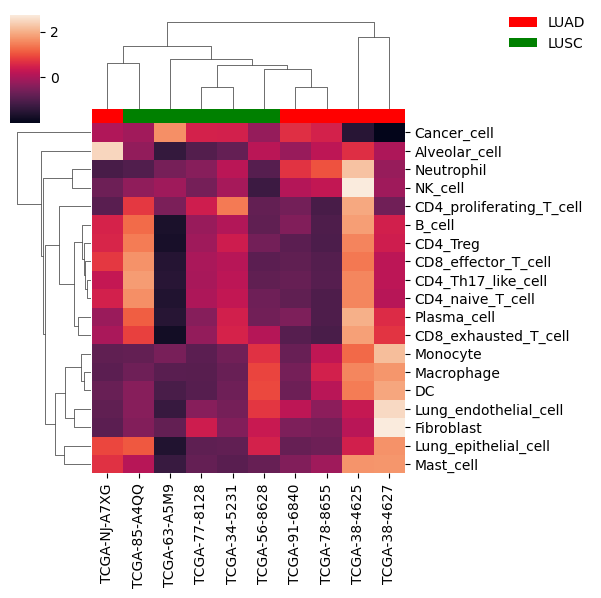

In [12]:
# add color annotation for LUAD/LUSC: First 5 samples are LUAD and the second 5 are LUSC
Subtype_colors = ['red']*5+['green']*5
# plot clustermap
map = sns.clustermap(zscore(Fractions).transpose(), figsize = (6,6),col_colors=Subtype_colors)
# add color legend
plt.legend([Patch(facecolor=col) for col in ['red','green']], ['LUAD','LUSC'],
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right',frameon=False)

Since the histological subtype should mainly concern the malignant cells, difference in their gene expression profiles should be reflected in the estimated cell type-specific gene expression profiles.
Therefore, when clustering these malignant profiles, a split between LUAD an LUSC is expected.


/home/anoyaro/anaconda3/envs/OncoBLADE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/anoyaro/anaconda3/envs/OncoBLADE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


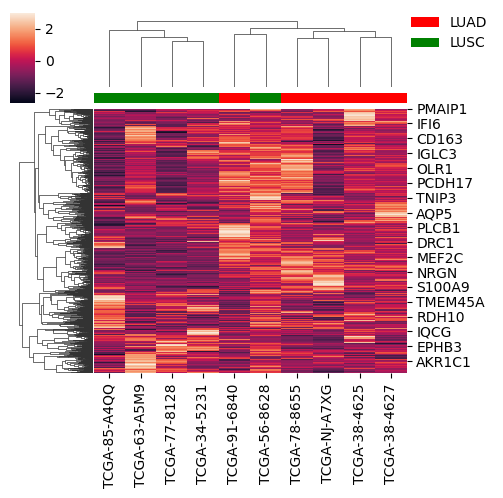

In [13]:
# plot clustermap
map = sns.clustermap(zscore(Malignant_cell_profiles).transpose(), figsize = (5,5),col_colors=Subtype_colors, metric = 'correlation')
# add color legend
plt.legend([Patch(facecolor=col) for col in ['red','green']], ['LUAD','LUSC'],
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right',frameon=False)